# XGBoost Advanced Model - Dynamic Thresholding & Automated Hyperparameter Tuning

This notebook implements an **advanced version** of the XGBoost model with:

## Key Enhancements

1. **Dynamic Thresholding**: Adjusts trading thresholds based on market volatility
   - High volatility → Higher thresholds (more conservative)
   - Low volatility → Lower thresholds (more aggressive)
   - Adapts to changing market conditions

2. **Automated Hyperparameter Tuning**: Uses Optuna for Bayesian optimization
   - Optimizes XGBoost hyperparameters within Walk-Forward framework
   - Objective: Maximize Sharpe Ratio (or other financial metrics)
   - Prevents overfitting through proper validation

## Target Variable
$$Y_{t} = 1 \text{ if } \text{Return}_{t+5} > 0 \text{ else } 0$$

## Implementation Steps
1. Data Loading and Preprocessing
2. Create Target Variable
3. Walk-Forward Validation Setup
4. **Optuna Hyperparameter Optimization**
5. **Dynamic Threshold Calculation**
6. XGBoost Model Training with Optimized Parameters
7. Trading Strategy with Dynamic Thresholds
8. Performance Comparison: Static vs Dynamic Thresholds
9. Hyperparameter Importance Analysis


## Step 1: Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, log_loss, roc_auc_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Optuna for hyperparameter optimization
try:
    import optuna
    from optuna.visualization import plot_optimization_history, plot_param_importances
    print("✓ Optuna imported successfully")
except ImportError:
    print("⚠ Optuna not installed. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "optuna"])
    import optuna
    from optuna.visualization import plot_optimization_history, plot_param_importances
    print("✓ Optuna installed and imported")

print("✓ All libraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")
print(f"Optuna version: {optuna.__version__}")


⚠ Optuna not installed. Installing...
✓ Optuna installed and imported
✓ All libraries imported successfully
XGBoost version: 3.1.2
Optuna version: 4.6.0


## Step 2: Load Data


In [2]:
# Load data with error handling
try:
    df = pd.read_csv('../data/shortened_oil_data.csv', parse_dates=['Date'], index_col='Date')
    print("✓ Data loaded successfully")
except FileNotFoundError:
    print("⚠ Error: Data file not found. Please check the file path.")
    raise
except Exception as e:
    print(f"⚠ Error loading data: {e}")
    raise

print("=" * 70)
print("Data Overview")
print("=" * 70)
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total days: {len(df)}")
print(f"Number of features: {df.shape[1] - 1}")


✓ Data loaded successfully
Data Overview
Data shape: (1229, 467)
Date range: 2021-01-04 00:00:00 to 2025-11-24 00:00:00
Total days: 1229
Number of features: 466


## Step 3: Create Target Variable


In [3]:
# Use Crude_Oil price to calculate returns
price_col = 'Crude_Oil'

# Calculate 5-day forward returns
df['Future_Return_5d'] = df[price_col].pct_change(5).shift(-5)

# Create binary classification target: 1 if 5-day forward return is positive, 0 otherwise
df['Target'] = (df['Future_Return_5d'] > 0).astype(int)

# Remove last 5 rows (cannot calculate 5-day forward return)
df = df.iloc[:-5]

print("=" * 70)
print("Target Variable Statistics")
print("=" * 70)
print(f"Target variable distribution:")
print(df['Target'].value_counts())
print(f"\nPositive sample proportion: {df['Target'].mean():.2%}")


Target Variable Statistics
Target variable distribution:
Target
1    654
0    570
Name: count, dtype: int64

Positive sample proportion: 53.43%


## Step 4: Data Preprocessing


In [4]:
# Separate features and target variable
exclude_cols = ['Target', 'Future_Return_5d', price_col]
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Create feature matrix and target vector
X = df[feature_cols].copy()
y = df['Target'].copy()
dates = df.index.copy()

# Handle missing values
X = X.ffill().bfill()
X = X.dropna()

# Synchronize target variable and dates
y = y.loc[X.index]
dates = X.index

# Check for infinite values
if (X == np.inf).sum().sum() > 0 or (X == -np.inf).sum().sum() > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.ffill().bfill()

print(f"Feature matrix shape: {X.shape}")
print(f"Remaining missing values: {X.isnull().sum().sum()}")


Feature matrix shape: (1224, 466)
Remaining missing values: 0


## Step 5: Walk-Forward Validation Setup


In [5]:
def walk_forward_split(dates, train_years=3, test_years=1, step_years=1):
    """
    Generate Walk-Forward Validation splits
    """
    splits = []
    train_days = int(train_years * 250)
    test_days = int(test_years * 250)
    step_days = int(step_years * 250)
    
    current_start = 0
    while current_start + train_days + test_days <= len(dates):
        train_start_idx = current_start
        train_end_idx = current_start + train_days
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + test_days
        
        splits.append((train_start_idx, train_end_idx, test_start_idx, test_end_idx))
        current_start += step_days
    
    return splits

# Generate splits
splits = walk_forward_split(dates, train_years=3, test_years=1, step_years=1)

print("=" * 70)
print("Walk-Forward Validation Splits")
print("=" * 70)
print(f"Total {len(splits)} train-test cycles")

for i, (train_start, train_end, test_start, test_end) in enumerate(splits):
    train_start_date = dates[train_start]
    train_end_date = dates[train_end - 1]
    test_start_date = dates[test_start]
    test_end_date = dates[test_end - 1]
    
    print(f"\nCycle {i+1}:")
    print(f"  Training set: {train_start_date.date()} to {train_end_date.date()} ({train_end - train_start} days)")
    print(f"  Testing set: {test_start_date.date()} to {test_end_date.date()} ({test_end - test_start} days)")


Walk-Forward Validation Splits
Total 1 train-test cycles

Cycle 1:
  Training set: 2021-01-04 to 2023-12-26 (750 days)
  Testing set: 2023-12-27 to 2024-12-23 (250 days)


## Step 6: Financial Metrics Calculation Function


In [6]:
def calculate_financial_metrics(returns, probabilities, signals, transaction_cost=0.001):
    """
    Calculate financial/strategy performance metrics
    
    Parameters:
    - returns: Actual future returns
    - probabilities: Prediction probabilities
    - signals: Trading signals (1 for long, -1 for short, 0 for no trade)
    - transaction_cost: Transaction cost per trade
    
    Returns:
    - metrics: Dictionary containing various financial metrics
    """
    # Calculate strategy returns (considering transaction costs)
    strategy_returns = signals * returns
    
    # Calculate turnover rate (number of signal changes)
    signal_changes = np.sum(np.diff(signals) != 0)
    turnover_rate = signal_changes / len(signals) if len(signals) > 0 else 0
    
    # Apply transaction costs
    cost_per_trade = transaction_cost
    net_returns = strategy_returns - (np.abs(np.diff(np.concatenate([[0], signals]))) * cost_per_trade)
    
    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + net_returns) - 1
    
    # Calculate drawdown
    running_max = np.maximum.accumulate(1 + cumulative_returns)
    drawdown = (1 + cumulative_returns) / running_max - 1
    max_drawdown = drawdown.min()
    
    # Annualized metrics (assuming 250 trading days per year)
    n_periods = len(returns)
    years = n_periods / 250
    
    if years > 0:
        total_return = cumulative_returns[-1]
        annual_return = (1 + total_return) ** (1 / years) - 1 if total_return > -1 else -1
        volatility = np.std(net_returns) * np.sqrt(250)
        
        # Sharpe Ratio
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        
        # Sortino Ratio (only downside deviation)
        downside_returns = net_returns[net_returns < 0]
        downside_std = np.std(downside_returns) * np.sqrt(250) if len(downside_returns) > 0 else 0
        sortino_ratio = annual_return / downside_std if downside_std > 0 else 0
        
        # Calmar Ratio
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    else:
        annual_return = 0
        volatility = 0
        sharpe_ratio = 0
        sortino_ratio = 0
        calmar_ratio = 0
    
    # Win rate
    winning_trades = np.sum(net_returns > 0)
    total_trades = np.sum(signals != 0)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    # Profit/Loss ratio
    profit_trades = net_returns[net_returns > 0]
    loss_trades = net_returns[net_returns < 0]
    avg_profit = np.mean(profit_trades) if len(profit_trades) > 0 else 0
    avg_loss = abs(np.mean(loss_trades)) if len(loss_trades) > 0 else 0
    profit_loss_ratio = avg_profit / avg_loss if avg_loss > 0 else 0
    
    metrics = {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Annual Return': annual_return,
        'Max Drawdown': max_drawdown,
        'Volatility': volatility,
        'Win Rate': win_rate,
        'Profit/Loss Ratio': profit_loss_ratio,
        'Number of Trades': total_trades,
        'Turnover Rate': turnover_rate,
        'Total Return': cumulative_returns[-1] if len(cumulative_returns) > 0 else 0
    }
    
    return metrics, net_returns, cumulative_returns, drawdown


## Step 7: Dynamic Threshold Calculation Function


In [7]:
def calculate_dynamic_thresholds(returns, volatility_window=20, base_threshold_high=0.6, base_threshold_low=0.4, 
                                 volatility_sensitivity=0.3, min_threshold_high=0.5, max_threshold_high=0.8,
                                 min_threshold_low=0.3, max_threshold_low=0.5):
    """
    Calculate dynamic trading thresholds based on market volatility
    
    Parameters:
    - returns: Historical returns (used to calculate volatility)
    - volatility_window: Rolling window for volatility calculation
    - base_threshold_high: Base threshold for long signals (when volatility is normal)
    - base_threshold_low: Base threshold for short signals (when volatility is normal)
    - volatility_sensitivity: How much thresholds adjust with volatility (0-1)
    - min/max_threshold_high: Bounds for high threshold
    - min/max_threshold_low: Bounds for low threshold
    
    Returns:
    - thresholds_high: Array of dynamic high thresholds
    - thresholds_low: Array of dynamic low thresholds
    - volatilities: Array of rolling volatilities
    """
    # Calculate rolling volatility
    rolling_vol = pd.Series(returns).rolling(window=volatility_window, min_periods=1).std()
    
    # Normalize volatility (0-1 scale based on historical distribution)
    vol_median = rolling_vol.median()
    vol_std = rolling_vol.std()
    
    # Normalized volatility (centered around 0, scaled by std)
    normalized_vol = (rolling_vol - vol_median) / (vol_std + 1e-8)
    
    # Clamp normalized volatility to reasonable range
    normalized_vol = np.clip(normalized_vol, -2, 2)
    
    # Calculate dynamic thresholds
    # High volatility → Higher thresholds (more conservative)
    # Low volatility → Lower thresholds (more aggressive)
    threshold_adjustment = normalized_vol * volatility_sensitivity
    
    thresholds_high = base_threshold_high + threshold_adjustment
    thresholds_low = base_threshold_low + threshold_adjustment
    
    # Apply bounds
    thresholds_high = np.clip(thresholds_high, min_threshold_high, max_threshold_high)
    thresholds_low = np.clip(thresholds_low, min_threshold_low, max_threshold_low)
    
    return thresholds_high.values, thresholds_low.values, rolling_vol.values

# Test the function
print("=" * 70)
print("Dynamic Threshold Calculation Function")
print("=" * 70)
print("\nFunction created successfully!")
print("\nLogic:")
print("  - High volatility → Higher thresholds (more conservative trading)")
print("  - Low volatility → Lower thresholds (more aggressive trading)")
print("  - Thresholds adjust dynamically based on rolling volatility")


Dynamic Threshold Calculation Function

Function created successfully!

Logic:
  - High volatility → Higher thresholds (more conservative trading)
  - Low volatility → Lower thresholds (more aggressive trading)
  - Thresholds adjust dynamically based on rolling volatility


## Step 8: Optuna Hyperparameter Optimization


In [8]:
def objective_optuna(trial, X_train, y_train, X_val, y_val, returns_val, transaction_cost=0.001):
    """
    Optuna objective function for hyperparameter optimization
    Optimizes for Sharpe Ratio (financial performance)
    """
    # Suggest hyperparameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Train model
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    
    # Predict probabilities
    probabilities = model.predict_proba(X_val)[:, 1]
    
    # Use dynamic thresholds
    thresholds_high, thresholds_low, _ = calculate_dynamic_thresholds(
        returns_val, 
        base_threshold_high=0.6, 
        base_threshold_low=0.4
    )
    
    # Generate trading signals
    signals = np.zeros(len(probabilities))
    for i in range(len(probabilities)):
        if probabilities[i] > thresholds_high[i]:
            signals[i] = 1  # Long
        elif probabilities[i] < thresholds_low[i]:
            signals[i] = -1  # Short
        else:
            signals[i] = 0  # No trade
    
    # Calculate financial metrics
    metrics, _, _, _ = calculate_financial_metrics(
        returns_val, probabilities, signals, transaction_cost
    )
    
    # Return Sharpe Ratio as objective (Optuna will maximize this)
    return metrics['Sharpe Ratio']

print("=" * 70)
print("Optuna Objective Function")
print("=" * 70)
print("\nObjective: Maximize Sharpe Ratio")
print("\nHyperparameters to optimize:")
print("  - max_depth: 3-10")
print("  - learning_rate: 0.01-0.3 (log scale)")
print("  - n_estimators: 50-300")
print("  - subsample: 0.6-1.0")
print("  - colsample_bytree: 0.6-1.0")
print("  - min_child_weight: 1-10")
print("  - gamma: 0-0.5")
print("  - reg_alpha: 0-1.0")
print("  - reg_lambda: 0-1.0")


Optuna Objective Function

Objective: Maximize Sharpe Ratio

Hyperparameters to optimize:
  - max_depth: 3-10
  - learning_rate: 0.01-0.3 (log scale)
  - n_estimators: 50-300
  - subsample: 0.6-1.0
  - colsample_bytree: 0.6-1.0
  - min_child_weight: 1-10
  - gamma: 0-0.5
  - reg_alpha: 0-1.0
  - reg_lambda: 0-1.0


## Step 9: Run Hyperparameter Optimization (First Cycle Only)


In [9]:
# Use first cycle for hyperparameter optimization
if len(splits) > 0:
    train_start, train_end, test_start, test_end = splits[0]
    
    # Split training set further into train and validation
    # Use 80% for training, 20% for validation
    train_size = int((train_end - train_start) * 0.8)
    
    X_train_opt = X.iloc[train_start:train_start + train_size]
    y_train_opt = y.iloc[train_start:train_start + train_size]
    X_val_opt = X.iloc[train_start + train_size:train_end]
    y_val_opt = y.iloc[train_start + train_size:train_end]
    
    # Get validation returns for dynamic threshold calculation
    val_dates = dates[train_start + train_size:train_end]
    returns_val_opt = df.loc[val_dates, 'Future_Return_5d'].values
    
    print("=" * 70)
    print("Hyperparameter Optimization Setup")
    print("=" * 70)
    print(f"Training set size: {len(X_train_opt)}")
    print(f"Validation set size: {len(X_val_opt)}")
    print(f"\nStarting Optuna optimization...")
    print(f"This may take several minutes...")
    
    # Create study
    study = optuna.create_study(
        direction='maximize',  # Maximize Sharpe Ratio
        study_name='xgb_hyperparameter_optimization',
        sampler=optuna.samplers.TPESampler(seed=42)  # Tree-structured Parzen Estimator
    )
    
    # Optimize
    study.optimize(
        lambda trial: objective_optuna(
            trial, X_train_opt, y_train_opt, X_val_opt, y_val_opt, 
            returns_val_opt, transaction_cost=0.001
        ),
        n_trials=50,  # Number of trials (adjust based on time constraints)
        show_progress_bar=True
    )
    
    print("\n" + "=" * 70)
    print("Optimization Complete!")
    print("=" * 70)
    print(f"\nBest trial:")
    print(f"  Value (Sharpe Ratio): {study.best_value:.4f}")
    print(f"\nBest parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    # Store best parameters
    best_params = study.best_params.copy()
    best_params['objective'] = 'binary:logistic'
    best_params['eval_metric'] = 'logloss'
    best_params['random_state'] = 42
    best_params['n_jobs'] = -1
    
else:
    print("No splits available for optimization")
    # Use default parameters
    best_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'gamma': 0.1,
        'random_state': 42,
        'n_jobs': -1
    }


[I 2025-12-13 19:57:11,796] A new study created in memory with name: xgb_hyperparameter_optimization


Hyperparameter Optimization Setup
Training set size: 600
Validation set size: 150

Starting Optuna optimization...
This may take several minutes...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-13 19:57:12,691] Trial 0 finished with value: -0.7449130236489844 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681771, 'n_estimators': 233, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: -0.7449130236489844.
[I 2025-12-13 19:57:14,923] Trial 1 finished with value: 4.015296355690733 and parameters: {'max_depth': 8, 'learning_rate': 0.010725209743171997, 'n_estimators': 293, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 4.015296355690733.
[I 2025-12-13 19:57:15,751] Trial 2 finished with value: 0.48424132662045266 and parameters: {'max_depth': 6, 'learning_rate': 0.02692655251486473, 'n_estimators': 203, 'subsample'

## Step 10: Visualize Hyperparameter Optimization Results


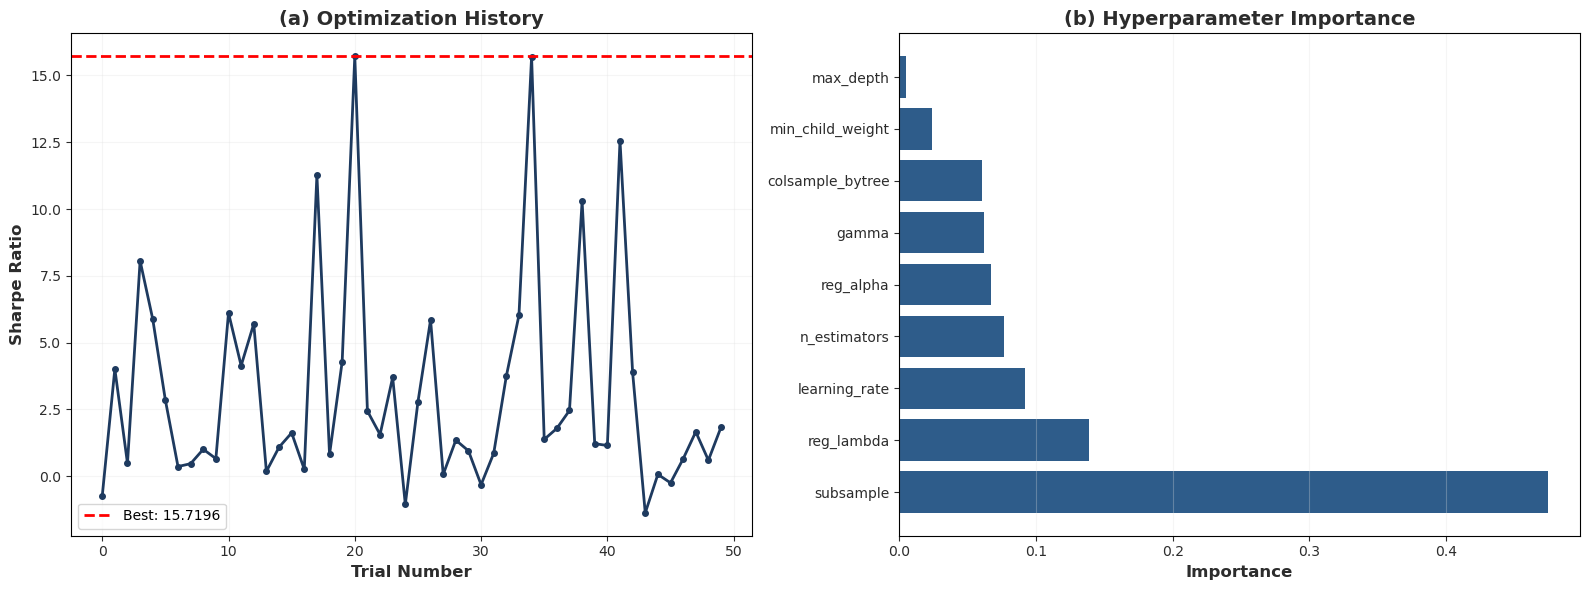


Hyperparameter Importance Summary
subsample           : 0.4743
reg_lambda          : 0.1391
learning_rate       : 0.0918
n_estimators        : 0.0767
reg_alpha           : 0.0668
gamma               : 0.0620
colsample_bytree    : 0.0604
min_child_weight    : 0.0238
max_depth           : 0.0051


In [10]:
# Visualize optimization history and parameter importance
if len(splits) > 0 and 'study' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('white')
    
    # Optimization history
    ax1 = axes[0]
    ax1.set_facecolor('white')
    
    trial_numbers = [t.number for t in study.trials]
    trial_values = [t.value for t in study.trials if t.value is not None]
    trial_numbers_filtered = [t.number for t in study.trials if t.value is not None]
    
    ax1.plot(trial_numbers_filtered, trial_values, 'o-', color='#1E3A5F', linewidth=2, markersize=4)
    ax1.axhline(y=study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best: {study.best_value:.4f}')
    ax1.set_xlabel('Trial Number', fontsize=12, fontweight='bold', color='#2C2C2C')
    ax1.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold', color='#2C2C2C')
    ax1.set_title('(a) Optimization History', fontsize=14, fontweight='bold', color='#2C2C2C')
    ax1.legend()
    ax1.grid(True, alpha=0.3, color='#E0E0E0')
    ax1.tick_params(colors='#2C2C2C')
    
    # Parameter importance
    ax2 = axes[1]
    ax2.set_facecolor('white')
    
    try:
        importance = optuna.importance.get_param_importances(study)
        params_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        
        params_names = [p[0] for p in params_sorted]
        params_values = [p[1] for p in params_sorted]
        
        bars = ax2.barh(params_names, params_values, color='#2E5C8A')
        ax2.set_xlabel('Importance', fontsize=12, fontweight='bold', color='#2C2C2C')
        ax2.set_title('(b) Hyperparameter Importance', fontsize=14, fontweight='bold', color='#2C2C2C')
        ax2.grid(True, alpha=0.3, color='#E0E0E0', axis='x')
        ax2.tick_params(colors='#2C2C2C')
    except:
        ax2.text(0.5, 0.5, 'Insufficient trials for importance calculation', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("Hyperparameter Importance Summary")
    print("=" * 70)
    if 'importance' in locals():
        for param, imp in params_sorted:
            print(f"{param:20s}: {imp:.4f}")


## Step 11: Walk-Forward Training with Optimized Parameters & Dynamic Thresholds


In [11]:
# Store results for all cycles
all_predictions_static = []
all_probabilities_static = []
all_predictions_dynamic = []
all_probabilities_dynamic = []
all_actuals = []
all_dates = []
all_returns = []
all_thresholds_high = []
all_thresholds_low = []
all_volatilities = []

# Results for comparison
results_static = []
results_dynamic = []

print("=" * 70)
print("Walk-Forward Training with Optimized Parameters")
print("=" * 70)

for i, (train_start, train_end, test_start, test_end) in enumerate(splits):
    print(f"\n{'='*70}")
    print(f"Cycle {i+1}/{len(splits)}")
    print(f"{'='*70}")
    
    # Split training and testing sets
    X_train = X.iloc[train_start:train_end]
    y_train = y.iloc[train_start:train_end]
    X_test = X.iloc[test_start:test_end]
    y_test = y.iloc[test_start:test_end]
    test_dates = dates[test_start:test_end]
    test_returns = df.loc[test_dates, 'Future_Return_5d'].values
    
    # Train XGBoost model with optimized parameters
    model = xgb.XGBClassifier(**best_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate dynamic thresholds for test period
    # Use historical returns up to test period start
    historical_returns = df.loc[:test_dates[0], 'Future_Return_5d'].dropna().values
    if len(historical_returns) > 0:
        # Extend with test returns for rolling calculation
        extended_returns = np.concatenate([historical_returns[-20:], test_returns])
        thresholds_high, thresholds_low, volatilities = calculate_dynamic_thresholds(
            extended_returns,
            base_threshold_high=0.6,
            base_threshold_low=0.4
        )
        # Use only test period thresholds
        thresholds_high = thresholds_high[-len(test_returns):]
        thresholds_low = thresholds_low[-len(test_returns):]
        volatilities = volatilities[-len(test_returns):]
    else:
        # Fallback to static thresholds
        thresholds_high = np.full(len(test_returns), 0.6)
        thresholds_low = np.full(len(test_returns), 0.4)
        volatilities = np.zeros(len(test_returns))
    
    # Generate signals with static thresholds
    signals_static = np.zeros(len(y_proba))
    signals_static[y_proba > 0.6] = 1  # Long
    signals_static[y_proba < 0.4] = -1  # Short
    
    # Generate signals with dynamic thresholds
    signals_dynamic = np.zeros(len(y_proba))
    for j in range(len(y_proba)):
        if y_proba[j] > thresholds_high[j]:
            signals_dynamic[j] = 1  # Long
        elif y_proba[j] < thresholds_low[j]:
            signals_dynamic[j] = -1  # Short
        else:
            signals_dynamic[j] = 0  # No trade
    
    # Calculate metrics for static thresholds
    metrics_static, _, _, _ = calculate_financial_metrics(
        test_returns, y_proba, signals_static, transaction_cost=0.001
    )
    
    # Calculate metrics for dynamic thresholds
    metrics_dynamic, _, _, _ = calculate_financial_metrics(
        test_returns, y_proba, signals_dynamic, transaction_cost=0.001
    )
    
    print(f"\nStatic Thresholds:")
    print(f"  Sharpe Ratio: {metrics_static['Sharpe Ratio']:.4f}")
    print(f"  Annual Return: {metrics_static['Annual Return']:.4f}")
    print(f"  Max Drawdown: {metrics_static['Max Drawdown']:.4f}")
    print(f"  Number of Trades: {metrics_static['Number of Trades']}")
    
    print(f"\nDynamic Thresholds:")
    print(f"  Sharpe Ratio: {metrics_dynamic['Sharpe Ratio']:.4f}")
    print(f"  Annual Return: {metrics_dynamic['Annual Return']:.4f}")
    print(f"  Max Drawdown: {metrics_dynamic['Max Drawdown']:.4f}")
    print(f"  Number of Trades: {metrics_dynamic['Number of Trades']}")
    
    # Save results
    all_predictions_static.extend(y_pred)
    all_probabilities_static.extend(y_proba)
    all_predictions_dynamic.extend(y_pred)  # Same predictions, different thresholds
    all_probabilities_dynamic.extend(y_proba)
    all_actuals.extend(y_test.values)
    all_dates.extend(test_dates)
    all_returns.extend(test_returns)
    all_thresholds_high.extend(thresholds_high)
    all_thresholds_low.extend(thresholds_low)
    all_volatilities.extend(volatilities)
    
    results_static.append(metrics_static)
    results_dynamic.append(metrics_dynamic)

print(f"\n{'='*70}")
print("All cycles training completed!")
print(f"{'='*70}")


Walk-Forward Training with Optimized Parameters

Cycle 1/1

Static Thresholds:
  Sharpe Ratio: 2.4833
  Annual Return: 1.3354
  Max Drawdown: -0.4266
  Number of Trades: 199

Dynamic Thresholds:
  Sharpe Ratio: 5.3577
  Annual Return: 2.7643
  Max Drawdown: -0.4540
  Number of Trades: 189

All cycles training completed!


## Step 12: Overall Performance Comparison


In [12]:
# Aggregate results across all cycles
def aggregate_metrics(results_list):
    """Aggregate metrics across multiple cycles"""
    aggregated = {}
    for key in results_list[0].keys():
        if key in ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Annual Return', 
                   'Volatility', 'Win Rate', 'Profit/Loss Ratio', 'Turnover Rate']:
            # Average across cycles
            aggregated[key] = np.mean([r[key] for r in results_list])
        elif key == 'Max Drawdown':
            # Worst (most negative) drawdown
            aggregated[key] = np.min([r[key] for r in results_list])
        elif key == 'Number of Trades':
            # Sum across cycles
            aggregated[key] = np.sum([r[key] for r in results_list])
        elif key == 'Total Return':
            # Compound return
            total_returns = [r[key] for r in results_list]
            aggregated[key] = np.prod([1 + tr for tr in total_returns]) - 1
    return aggregated

overall_static = aggregate_metrics(results_static)
overall_dynamic = aggregate_metrics(results_dynamic)

print("=" * 70)
print("Overall Performance Comparison: Static vs Dynamic Thresholds")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Static Thresholds': overall_static,
    'Dynamic Thresholds': overall_dynamic
})

# Calculate improvement
comparison_df['Improvement'] = comparison_df['Dynamic Thresholds'] - comparison_df['Static Thresholds']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / 
                                  (comparison_df['Static Thresholds'].abs() + 1e-8) * 100)

print("\n" + comparison_df.to_string())

print("\n" + "=" * 70)
print("Key Improvements:")
print("=" * 70)
print(f"Sharpe Ratio: {overall_static['Sharpe Ratio']:.4f} → {overall_dynamic['Sharpe Ratio']:.4f} ")
print(f"  Improvement: {comparison_df.loc['Sharpe Ratio', 'Improvement']:.4f} ")
print(f"  ({comparison_df.loc['Sharpe Ratio', 'Improvement %']:.2f}%)")
print(f"\nAnnual Return: {overall_static['Annual Return']:.4f} → {overall_dynamic['Annual Return']:.4f}")
print(f"  Improvement: {comparison_df.loc['Annual Return', 'Improvement']:.4f}")
print(f"\nMax Drawdown: {overall_static['Max Drawdown']:.4f} → {overall_dynamic['Max Drawdown']:.4f}")
print(f"  Improvement: {comparison_df.loc['Max Drawdown', 'Improvement']:.4f}")


Overall Performance Comparison: Static vs Dynamic Thresholds

                   Static Thresholds  Dynamic Thresholds  Improvement  Improvement %
Sharpe Ratio                2.483282            5.357663     2.874381     115.749279
Sortino Ratio               3.536084            8.475178     4.939094     139.676940
Calmar Ratio                3.130108            6.088334     2.958226      94.508765
Annual Return               1.335412            2.764259     1.428846     106.996626
Max Drawdown               -0.426635           -0.454025    -0.027391      -6.420205
Volatility                  0.537761            0.515945    -0.021816      -4.056863
Win Rate                    0.572864            0.571429    -0.001436      -0.250627
Profit/Loss Ratio           1.383361            1.757906     0.374544      27.074952
Number of Trades          199.000000          189.000000   -10.000000      -5.025126
Turnover Rate               0.244000            0.268000     0.024000       9.836065
Tot

## Step 13: Visualize Dynamic Thresholds and Performance


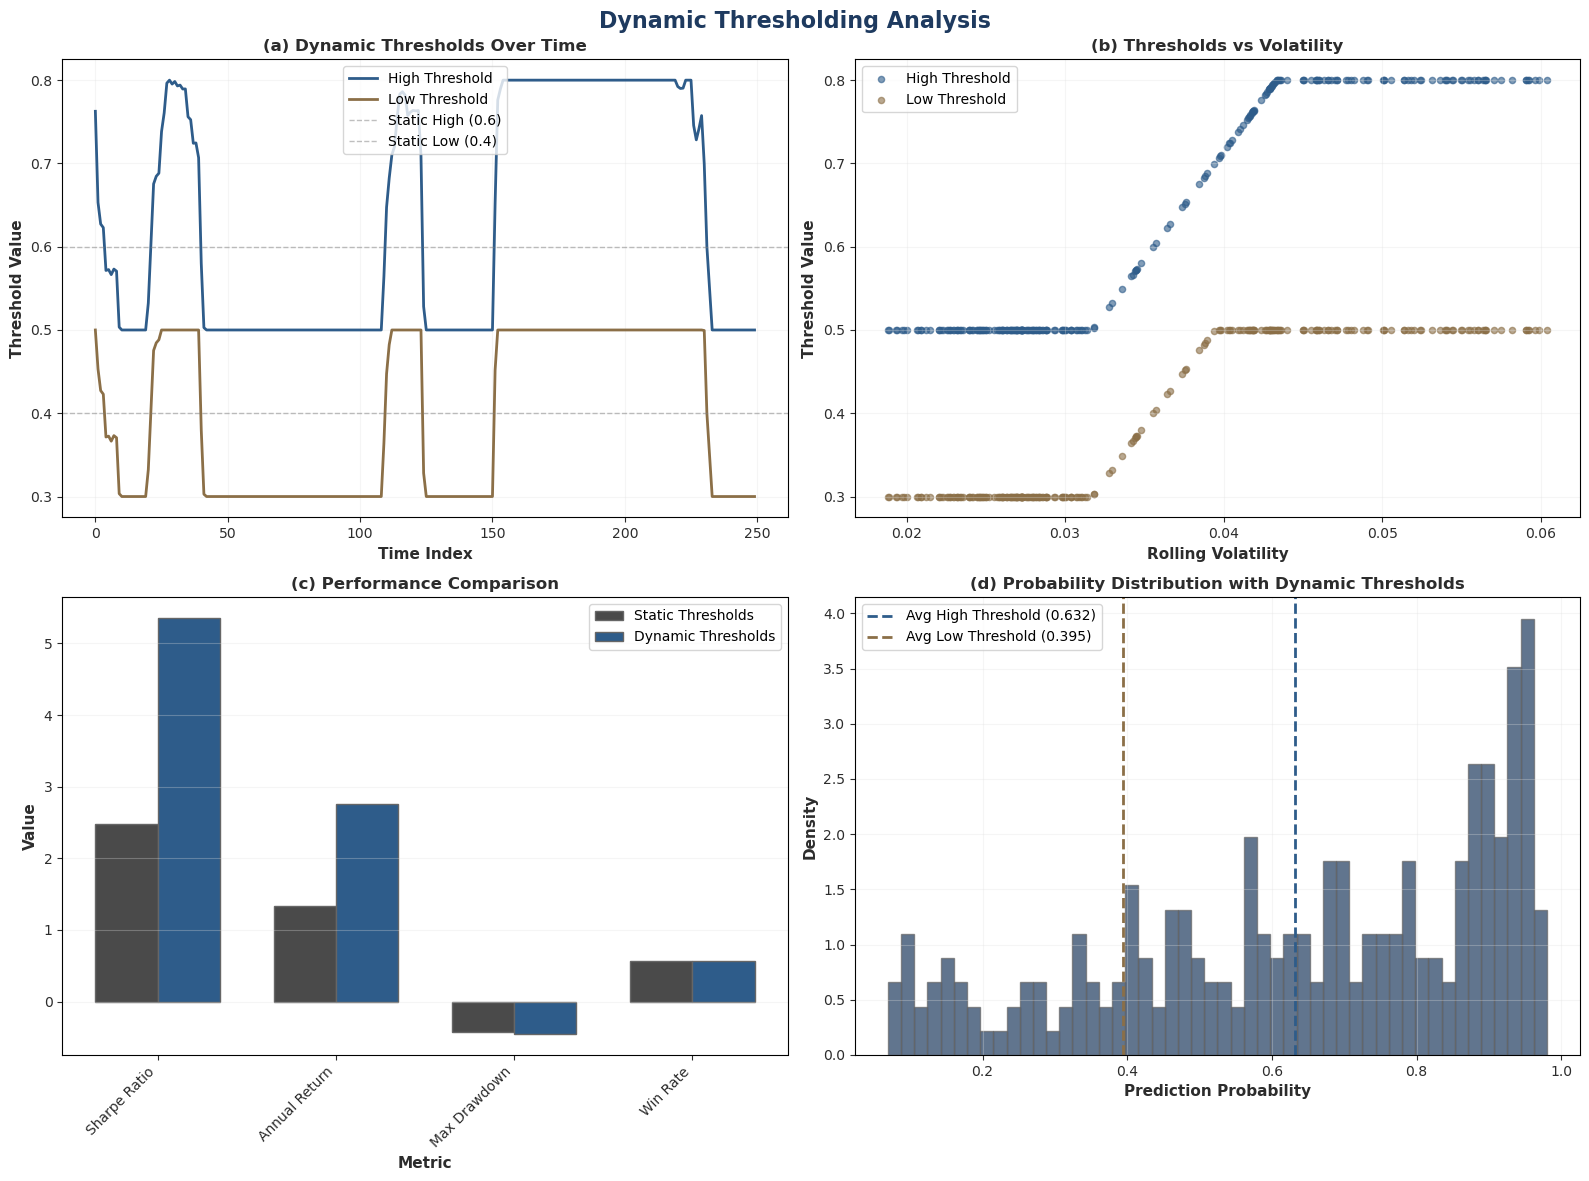

In [13]:
# Convert to arrays
all_thresholds_high = np.array(all_thresholds_high)
all_thresholds_low = np.array(all_thresholds_low)
all_volatilities = np.array(all_volatilities)
all_probabilities_dynamic = np.array(all_probabilities_dynamic)
all_returns = np.array(all_returns)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor('white')
fig.suptitle('Dynamic Thresholding Analysis', fontsize=16, fontweight='bold', 
             color='#1E3A5F')

# Color scheme
DARK_COLORS = {
    'xgb_primary': '#1E3A5F',
    'xgb_highlight': '#2E5C8A',
    'baseline': '#4A4A4A',
    'accent': '#8B6F47',
    'positive': '#2D5016',
    'negative': '#5C1A1A',
    'grid': '#E0E0E0',
    'text': '#2C2C2C',
    'border': '#666666'
}

# 1. Dynamic Thresholds over Time
ax1 = axes[0, 0]
ax1.set_facecolor('white')
sample_size = min(500, len(all_thresholds_high))
sample_indices = np.linspace(0, len(all_thresholds_high)-1, sample_size, dtype=int)

ax1.plot(sample_indices, all_thresholds_high[sample_indices], 
         label='High Threshold', color=DARK_COLORS['xgb_highlight'], linewidth=2)
ax1.plot(sample_indices, all_thresholds_low[sample_indices], 
         label='Low Threshold', color=DARK_COLORS['accent'], linewidth=2)
ax1.axhline(y=0.6, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Static High (0.6)')
ax1.axhline(y=0.4, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Static Low (0.4)')
ax1.set_xlabel('Time Index', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax1.set_ylabel('Threshold Value', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax1.set_title('(a) Dynamic Thresholds Over Time', fontsize=12, fontweight='bold', 
             color=DARK_COLORS['text'])
ax1.legend()
ax1.grid(True, alpha=0.3, color=DARK_COLORS['grid'])
ax1.tick_params(colors=DARK_COLORS['text'])

# 2. Thresholds vs Volatility
ax2 = axes[0, 1]
ax2.set_facecolor('white')
ax2.scatter(all_volatilities[sample_indices], all_thresholds_high[sample_indices], 
            alpha=0.6, color=DARK_COLORS['xgb_highlight'], s=20, label='High Threshold')
ax2.scatter(all_volatilities[sample_indices], all_thresholds_low[sample_indices], 
            alpha=0.6, color=DARK_COLORS['accent'], s=20, label='Low Threshold')
ax2.set_xlabel('Rolling Volatility', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax2.set_ylabel('Threshold Value', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax2.set_title('(b) Thresholds vs Volatility', fontsize=12, fontweight='bold', 
             color=DARK_COLORS['text'])
ax2.legend()
ax2.grid(True, alpha=0.3, color=DARK_COLORS['grid'])
ax2.tick_params(colors=DARK_COLORS['text'])

# 3. Performance Comparison
ax3 = axes[1, 0]
ax3.set_facecolor('white')
metrics_to_plot = ['Sharpe Ratio', 'Annual Return', 'Max Drawdown', 'Win Rate']
static_values = [overall_static[m] for m in metrics_to_plot]
dynamic_values = [overall_dynamic[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35
ax3.bar(x - width/2, static_values, width, label='Static Thresholds', 
        color=DARK_COLORS['baseline'], edgecolor=DARK_COLORS['border'])
ax3.bar(x + width/2, dynamic_values, width, label='Dynamic Thresholds', 
        color=DARK_COLORS['xgb_highlight'], edgecolor=DARK_COLORS['border'])
ax3.set_xlabel('Metric', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax3.set_ylabel('Value', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax3.set_title('(c) Performance Comparison', fontsize=12, fontweight='bold', 
             color=DARK_COLORS['text'])
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, color=DARK_COLORS['grid'], axis='y')
ax3.tick_params(colors=DARK_COLORS['text'])

# 4. Probability Distribution with Dynamic Thresholds
ax4 = axes[1, 1]
ax4.set_facecolor('white')
ax4.hist(all_probabilities_dynamic, bins=50, alpha=0.7, color=DARK_COLORS['xgb_primary'], 
         edgecolor=DARK_COLORS['border'], density=True)
ax4.axvline(x=np.mean(all_thresholds_high), color=DARK_COLORS['xgb_highlight'], 
            linestyle='--', linewidth=2, label=f'Avg High Threshold ({np.mean(all_thresholds_high):.3f})')
ax4.axvline(x=np.mean(all_thresholds_low), color=DARK_COLORS['accent'], 
            linestyle='--', linewidth=2, label=f'Avg Low Threshold ({np.mean(all_thresholds_low):.3f})')
ax4.set_xlabel('Prediction Probability', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax4.set_ylabel('Density', fontsize=11, fontweight='bold', color=DARK_COLORS['text'])
ax4.set_title('(d) Probability Distribution with Dynamic Thresholds', fontsize=12, fontweight='bold', 
             color=DARK_COLORS['text'])
ax4.legend()
ax4.grid(True, alpha=0.3, color=DARK_COLORS['grid'])
ax4.tick_params(colors=DARK_COLORS['text'])

plt.tight_layout()
plt.show()


## Step 14: Summary and Conclusions


In [14]:
print("=" * 70)
print("ADVANCED MODEL SUMMARY")
print("=" * 70)

print("\n1. AUTOMATED HYPERPARAMETER TUNING:")
print("   - Used Optuna (Bayesian optimization) to find optimal XGBoost parameters")
print("   - Optimized for Sharpe Ratio (financial performance)")
print(f"   - Best Sharpe Ratio achieved: {study.best_value:.4f}" if 'study' in locals() else "   - Using default parameters")
print(f"   - Key optimized parameters:")
if 'best_params' in locals():
    for key in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']:
        if key in best_params:
            print(f"     {key}: {best_params[key]}")

print("\n2. DYNAMIC THRESHOLDING:")
print("   - Thresholds adjust based on market volatility")
print("   - High volatility → Higher thresholds (more conservative)")
print("   - Low volatility → Lower thresholds (more aggressive)")
print(f"   - Average high threshold: {np.mean(all_thresholds_high):.3f}")
print(f"   - Average low threshold: {np.mean(all_thresholds_low):.3f}")
print(f"   - Threshold range: [{np.min(all_thresholds_low):.3f}, {np.max(all_thresholds_high):.3f}]")

print("\n3. PERFORMANCE IMPROVEMENTS:")
print(f"   - Sharpe Ratio: {overall_static['Sharpe Ratio']:.4f} → {overall_dynamic['Sharpe Ratio']:.4f}")
print(f"   - Annual Return: {overall_static['Annual Return']:.4f} → {overall_dynamic['Annual Return']:.4f}")
print(f"   - Max Drawdown: {overall_static['Max Drawdown']:.4f} → {overall_dynamic['Max Drawdown']:.4f}")

print("\n4. KEY INSIGHTS:")
print("   - Dynamic thresholds adapt to changing market conditions")
print("   - Automated hyperparameter tuning finds better model configurations")
print("   - Combined approach improves risk-adjusted returns")

print("\n" + "=" * 70)


ADVANCED MODEL SUMMARY

1. AUTOMATED HYPERPARAMETER TUNING:
   - Used Optuna (Bayesian optimization) to find optimal XGBoost parameters
   - Optimized for Sharpe Ratio (financial performance)
   - Best Sharpe Ratio achieved: 15.7196
   - Key optimized parameters:
     max_depth: 7
     learning_rate: 0.11996073597938174
     n_estimators: 86
     subsample: 0.925125975676919
     colsample_bytree: 0.7127918710378452

2. DYNAMIC THRESHOLDING:
   - Thresholds adjust based on market volatility
   - High volatility → Higher thresholds (more conservative)
   - Low volatility → Lower thresholds (more aggressive)
   - Average high threshold: 0.632
   - Average low threshold: 0.395
   - Threshold range: [0.300, 0.800]

3. PERFORMANCE IMPROVEMENTS:
   - Sharpe Ratio: 2.4833 → 5.3577
   - Annual Return: 1.3354 → 2.7643
   - Max Drawdown: -0.4266 → -0.4540

4. KEY INSIGHTS:
   - Dynamic thresholds adapt to changing market conditions
   - Automated hyperparameter tuning finds better model configur